# Tokyo Climate Forecast using Convolutional LSTM Network  

Section 1 and 2 deal with the data collection steps (web scrapping)  
Section 3 onwards load the scrapped data, model the climate forecast

## 1 Data collection

The data concerned is the mean daily maximum temperature which is released every month by the Japan Meteorological Agency.  
The data is available here: https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47662&view=2

In [ ]:
import requests
from bs4 import BeautifulSoup
url = "https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47662&view=2"

In [ ]:
result = requests.get(url).text
soup = BeautifulSoup(result)

data = []
table = soup.find_all('td', attrs={'class':'data_0_0_0_0'})

# The table includes the average temperature for the year (the annual column)
# The 'annual' column is discarded as the concern is the monthly temperature values
count = 1
for i, row in enumerate(table, 1):
    if i / count == 13: # skip the value at multiples of 13th, i.e. the annual column
        count += 1
        continue
    data.append(row.text.strip().split()[0])

In [ ]:
print("Total data points:{}\nFirst 12 data points: {}\nLast 12 data points:{}".format(len(data), data[:12], data[-12:]))

Total data points:1752
First 12 data points: ['ã\x80\x80', 'ã\x80\x80', 'ã\x80\x80', 'ã\x80\x80', 'ã\x80\x80', '25.5', '30.1', '29.4', '25.6', '19.9', '16.1', '10.2']
Last 12 data points:['10.3', '14.0', '17.9', '20.6', '24.1', '27.3', '30.3', '33.4', 'ã\x80\x80', 'ã\x80\x80', 'ã\x80\x80', 'ã\x80\x80']


The first and last 12 data points have missing values, therefore, only the years without missing values are considered, i.e. year 1876 - 2020

In [ ]:
# Take values for year 1876 - 2020
data = data[12:-12]
print("Total data points:{}\nNew first 12 data points: {}\nNew last 12 data points:{}".format(len(data), data[:12], data[-12:]))

Total data points:1728
New first 12 data points: ['6.6', '8.2', '13.6', '17.5', '21.7', '22.8', '28.6', '31.6', '26.8', '20.4', '15.8', '11.0']
New last 12 data points:['11.1', '13.3', '16.0', '18.2', '24.0', '27.5', '27.7', '34.1', '28.1', '21.4', '18.6', '12.3']


## 2 Back up data  
Let's save the data as csv file (as backup file, in case there is change in the website)


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
tokyo_data = "data/tokyo_max_temp.csv"
with open(tokyo_data, "w") as f:
    writer = csv.writer(f)
    writer.writerow(data)

## 3 Load data

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load from csv
series = []
with open("data/tokyo_max_temp.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        series.append(row)
series = list(map(float, series[0]))
print("Total data points: {}".format(len(series)))

Total data points: 1728


Visualize of the data:

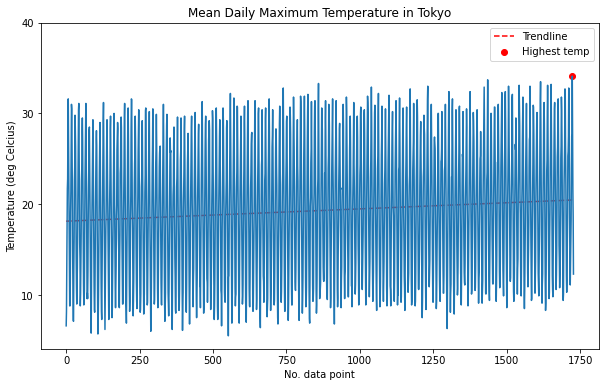

In [3]:
# time axis
time = np.arange(0, len(series))

# trendline
z = np.polyfit(time, series, 1)
p = np.poly1d(z)

# find the maximum
max_temp = max(series)
x_pos = series.index(max_temp)
max_arr = [None] * len(series)
max_arr[x_pos] = max_temp

# plot
plt.figure(figsize=(10, 6))
plt.plot(time, p(time), "r--", label="Trendline")
plt.plot(time, series)
plt.scatter(time, max_arr, color="red", label="Highest temp")
plt.xlabel("No. data point")
plt.ylabel("Temperature (deg Celcius)")
plt.yticks([10, 20, 30, 40])
plt.title("Mean Daily Maximum Temperature in Tokyo")
plt.legend()
plt.show()

**Observations**  
- The highest maximum mean daily temperature (red dot) is recorded at later data points (recent years)
- The trendline (red-dashed line) supports the finding about the red dot by illustrating how the mean daily temperature increases over the years; confirming that maximum mean daily temperature gradually increases over the years.  
- From this observation, we can expect the mean daily temperature for the next years keep increasing 

## 4 Data preparation

In [4]:
# take 80% of data as train set
train_size = 0.8
split_time = int(train_size * len(series))
# series data
series_train =  series[:split_time]
series_test = series[split_time:]
print("Number of data points for training: {}, for testing: {}".format(len(series_train), len(series_test)))
# time step data
time_train = time[:split_time]
time_test = time[split_time:]

Number of data points for training: 1382, for testing: 346


``Tensorflow Data`` API is used, enabling an effective way to feed the time series data in window manner. That is, data points as much as the *window* size are fed as inputs of the forecast model to predict one-step ahead data point.  
In this case, with ``window size`` of 24, 24 data points are taken as inputs, whereas the data point at one step ahead, e.g. the 25-th data point, is used as the target variable.  

In [5]:
# variables for window dataset
window_size = 24
batch_size = 64
shuffle_buffer_size = 1000

In [7]:
#from tensorflow.python.data import Dataset
import tensorflow as tf
#from tensorflow.data import Dataset
from tensorflow.python.data import Dataset

In [8]:
def window_dataset(series, window_size, batch_size, shuffle_buffer_size):
    '''
    windowing the time series data to be a windowed dataset
    
        Parameters:
            series: time series data 
            window_size: desired number of data points as inputs of the network
            batch_size: batching the input of the network
            shuffle_buffer_size: buffer size for shuffle method
            
        Returns:
            windowed dataset
    '''
    series = tf.expand_dims(series, axis=-1)
    ds = Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size + 1))
    ds = ds.map(lambda x: (x[:-1], x[-1:]))
    ds = ds.shuffle(shuffle_buffer_size)
    return ds.batch(batch_size).prefetch(1)

def forecast(model, series, window_size):
    '''
    forecasting the time series data
    
        Parameters:
            model: trained network model
            series: time series data to be forecasted
            window_size: desired number of data points as inputs of the network
            
        Returns:
            forecast: forecasted time series data
    '''
    series = tf.expand_dims(series, axis=-1)
    ds = Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
# create the windowed dataset
train_set = window_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

## 5 Modeling  
The convolutional LSTM network used is as demonstrated in https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction
It consists of a 1-D convolutional layer, two LSTM layers and followed by two fully-connected (FC) layers and an output layer. 

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Bidirectional, LSTM, Dense, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import LearningRateScheduler

In [21]:
def create_model():
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        LSTM(32, return_sequences=True),
        LSTM(32, return_sequences=True),
        Dense(30, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1),
        Lambda(lambda x: x * 400.0)
    ])
    return model

### 5.1 Tuning the learning rate

In [22]:
model = create_model()
model.compile(loss=Huber(), optimizer=SGD(learning_rate=1e-8, momentum=0.9), metrics=["mae"])

In [23]:
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
# fit
hist = model.fit(train_set, epochs=100, callbacks=[lr_scheduler])

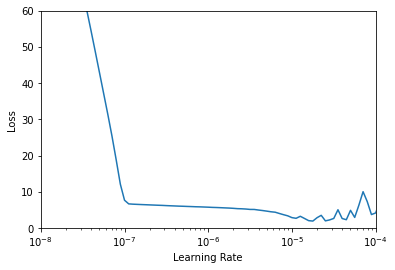

In [26]:
# check best lr value
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

From the learning rate plot above, the learning rate value of 1e-5 is the learning rate where the loss value is the lowest before the loss value starts to oscillate (unstable). Therefore, we pick the learning rate of 1e-5 as the learning rate to train the model

### 5.2 Fit the network using tuned learning rate

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_epochs = 100

model = create_model()
optimizer = SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=n_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
22/22 [==============================] - 3s 9ms/step - loss: 24.2884 - mae: 24.7805
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 6.3829 - mae: 6.8695
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 6.1041 - mae: 6.5902
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 5.8980 - mae: 6.3842
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 5.8332 - mae: 6.3184
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 5.6232 - mae: 6.1091
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 5.3998 - mae: 5.8847
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 5.2694 - mae: 5.7546
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 4.9920 - mae: 5.4750
Epoch 10/100
22/22 [==============================] - 0s 8ms/step - loss: 4.7074 - mae: 5.1892
Epoch 11/100
22/22 [==============================] - 0s 

No handles with labels found to put in legend.


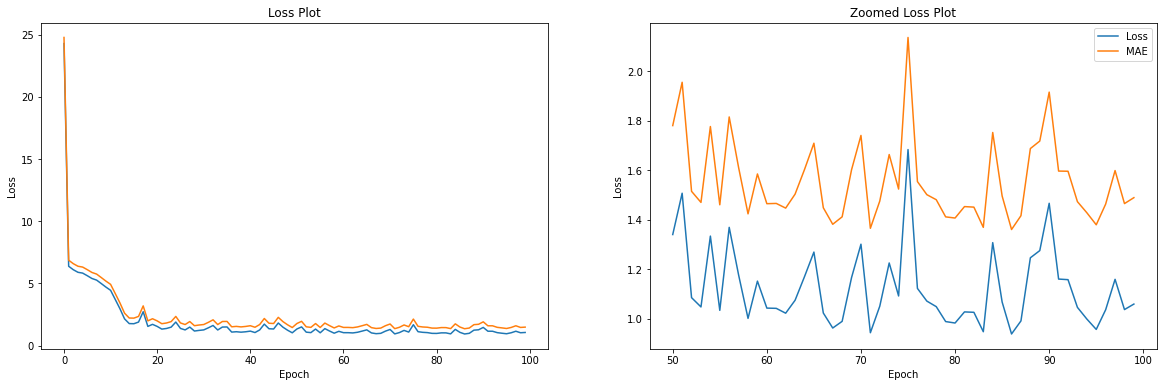

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.ravel()

axs[0].plot(range(n_epochs), history.history["loss"], label="Loss")
axs[0].plot(range(n_epochs), history.history["mae"], label="MAE")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Loss Plot")
plt.legend()

axs[1].plot(range(50, n_epochs), history.history["loss"][50:], label="Loss")
axs[1].plot(range(50, n_epochs), history.history["mae"][50:], label="MAE")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Zoomed Loss Plot")

plt.legend()
plt.show()

- The loss plot (left plot) shows that the loss value rapidly drops as the training starts. Afterwards, the loss value looks flat, although the loss value still decreases as seen in the zoomed plot (right plot).  
- After 100 epochs, the **training Huber loss value** is **1.059**, and the **MAE** is **1.489**
- Notice that the loss value (at the zoomed plot) actually oscillates and this behavior is normal because it is the nature of the stochastic gradient descent.

Now, let's check the performance of the test set by forecasting the test set:

In [34]:
from tensorflow.keras.metrics import mean_absolute_error

In [35]:
# forecasting on test set
lstm_forecast = forecast(model, series, window_size)
lstm_forecast_test = lstm_forecast[split_time - window_size:-1, -1, 0]
mean_absolute_error(series_test, lstm_forecast_test)

<tf.Tensor: shape=(), dtype=float32, numpy=1.386956>

- The convolutional LSTM network is able to generalize well on the **test set with MAE** score: **1.386**  

| Network | Train MAE | Test MAE |
| --- | --- | --- |
| Baseline | 1.489 | 1.386 |


Let's save the model for now

In [36]:
# save baseline network
model.save("model/forecast_lstm.h5", save_format="h5")

## 6 Hyperparameters tuning  
Wanted to see if better performance can be obtained. Next, focus on tuning:  
- number of filters and kernels for the 1-D convolutional layer
- number of LSTM and dense units  

To save time, split the tuning:

In [ ]:
def create_model(n_filters=32, k_size=3, LSTM_unit=32, dense1_unit=30, dense2_unit=10):
    model = Sequential([
        Conv1D(filters=n_filters, kernel_size=k_size, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        LSTM(LSTM_unit, return_sequences=True),
        LSTM(LSTM_unit, return_sequences=True),
        Dense(dense1_unit, activation='relu'),
        Dense(dense2_unit, activation='relu'),
        Dense(1),
        Lambda(lambda x: x * 400.0)
    ])
    return model

In [39]:
# tuning conv1D layer
n_epochs = 100
number_filters = [16, 32, 64]
number_kernels = [1, 3, 5]

results = {}
count = 1

for i in number_filters:
  for j in number_kernels:
    print("[INFO] Processing {} / 9...".format(count))

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    model = create_model(n_filters=i, k_size=j)
    optimizer = SGD(lr=1e-5, momentum=0.9)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(train_set, epochs=n_epochs, verbose=0)

    param = "{}filters_{}kernels".format(i, j)
    loss = history.history["loss"][-1]
    mae = history.history["mae"][-1]
    results[param] = [loss, mae]
    count += 1

[INFO] Processing 1 / 9...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[INFO] Processing 2 / 9...
[INFO] Processing 3 / 9...
[INFO] Processing 4 / 9...
[INFO] Processing 5 / 9...
[INFO] Processing 6 / 9...
[INFO] Processing 7 / 9...
[INFO] Processing 8 / 9...
[INFO] Processing 9 / 9...


In [44]:
best_result = sorted(results.items(), key=lambda item: item[1])[0]
print("Best result is {}, with loss value of {} and MAE of {}".format(best_result[0], best_result[1][0], best_result[1][1]))

Best result is 64filters_5kernels, with loss value of 0.8416585326194763 and MAE of 1.2558002471923828


In [45]:
# tuning number of LSTM and FC units using 1D conv layer with 64 filters and 5 kernels
number_LSTM_unit = [16, 32, 64]
number_dense1_unit = [10, 30, 50]
number_dense2_unit = [5, 10, 15]
n_epochs = 100

results = {}
count = 1

for i in number_LSTM_unit:
  for j in number_dense1_unit:
    for k in number_dense2_unit:
      print("processing {} / 27".format(count))

      tf.keras.backend.clear_session()
      tf.random.set_seed(42)
      np.random.seed(42)

      model = create_model(n_filters=64, k_size=5, LSTM_unit=i, dense1_unit=j, dense2_unit=k)
      optimizer = SGD(lr=1e-5, momentum=0.9)
      model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
      history = model.fit(train_set, epochs=n_epochs, verbose=0)

      param = "{}LSTM_{}dense1_{}dense2".format(i, j, k)
      loss = history.history["loss"][-1]
      mae = history.history["mae"][-1]
      results[param] = [loss, mae]
      count += 1

processing 1 / 27


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


processing 2 / 27
processing 3 / 27
processing 4 / 27
processing 5 / 27
processing 6 / 27
processing 7 / 27
processing 8 / 27
processing 9 / 27
processing 10 / 27
processing 11 / 27
processing 12 / 27
processing 13 / 27
processing 14 / 27
processing 15 / 27
processing 16 / 27
processing 17 / 27
processing 18 / 27
processing 19 / 27
processing 20 / 27
processing 21 / 27
processing 22 / 27
processing 23 / 27
processing 24 / 27
processing 25 / 27
processing 26 / 27
processing 27 / 27


In [48]:
best_result = sorted(results.items(), key=lambda item: item[1])[0]
print("Best result is {}, with loss value of {} and MAE of {}".format(best_result[0], best_result[1][0], best_result[1][1]))

Best result is 64LSTM_30dense1_10dense2, with loss value of 0.8321921229362488 and MAE of 1.2466670274734497


Hyperparameters tuning is done. Now, let's build the best network, train it:

In [ ]:
# using best model
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_epochs = 100
model = create_model(64, 5, 64, 30, 10)
optimizer = SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
H = model.fit(train_set, epochs=n_epochs, verbose=1)

In [51]:
print("The loss value is {} and MAE is {}".format(H.history["loss"][-1], H.history["mae"][-1]))

The loss value is 0.8445029854774475 and MAE is 1.2575064897537231


The plot:

No handles with labels found to put in legend.


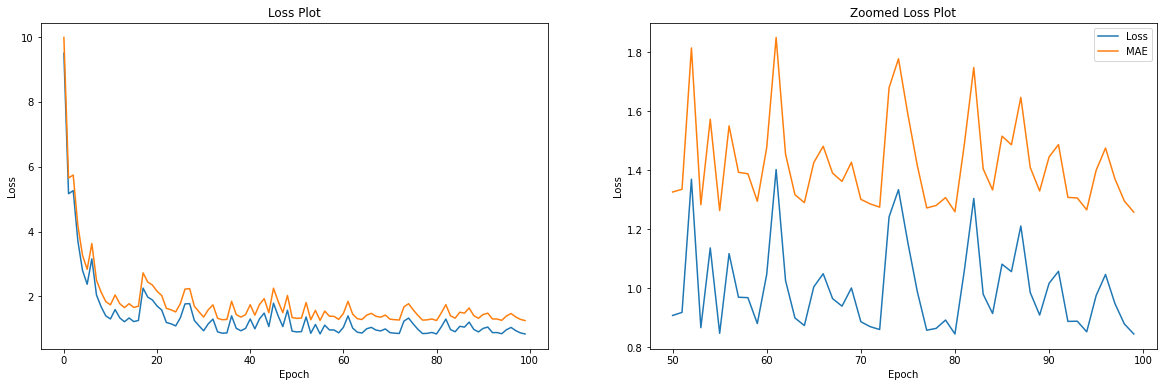

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.ravel()

axs[0].plot(range(n_epochs), H.history["loss"], label="Loss")
axs[0].plot(range(n_epochs), H.history["mae"], label="MAE")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Loss Plot")
plt.legend()

axs[1].plot(range(50, n_epochs), H.history["loss"][50:], label="Loss")
axs[1].plot(range(50, n_epochs), H.history["mae"][50:], label="MAE")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Zoomed Loss Plot")

plt.legend()
plt.show()

- Similarly, the loss plot of the tuned network rapidly decreased for the first 20 epochs. 
- The **training Huber loss value** of **0.844** with **MAE** score of **1.257**
- Comparing the tuned network's loss plot to the baseline network's loss plot, we can see that the oscillation of the loss and MAE value in the tuned network is higher  

Now, let's backup the tuned model, then forecast the test set using the tuned network:

In [ ]:
model.save("model/finetuned_forecast_lstm.h5", save_format="h5")

In [52]:
# forecast the test set using fine-tuned model
new_forecast = forecast(model, series, window_size)
new_forecast = new_forecast[split_time - window_size:-1, -1, 0]
mean_absolute_error(series_test, new_forecast)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3237183>

In general, the performance on the test set using tuned network is slightly better.  
The summary of performance of the networks: 

| Network | Train Huber loss | Train MAE | Test MAE |
| --- | --- | --- | --- |
| Baseline | 1.059 | 1.489 | 1.386 |
| Tuned | 0.844 | 1.257 | 1.323 |  

Let's plot the forecasted data points using the tuned model compared to the ground truth test set:

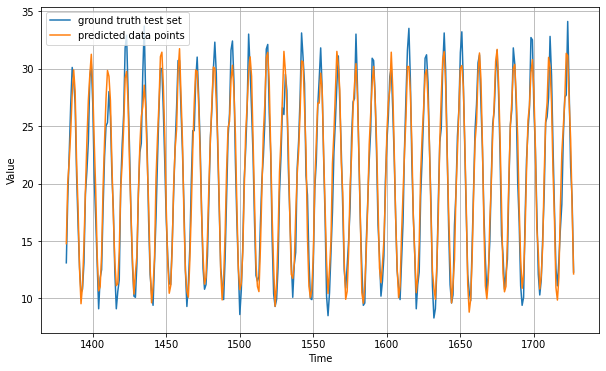

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, series_test, label="ground truth test set")
plt.plot(time_test, new_forecast, label="predicted data points")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

- The orange line, i.e. the predicted (forecasted) data points is generally able to follow the ground truth test data points, although not perfectly fit (the average error value to the ground truth data is the MAE value, which is 1.323)

## 7 Forecasting 2021 temperature

Recall that several last data points (data from Jan - Jul 2021) scrapped from the Japan Meteorological Agency are ignored. Now, let's forecast those data (Jan - Jul 2021) using the tuned model:

In [61]:
new_series = series[:] # copy the time series data
for _ in range(7):
  forecasted = forecast(model, new_series, window_size)
  new_data_point = forecasted[-1, -1, 0]
  new_series.append(new_data_point)
print("Last 10 temperatures: {}".format(new_series[-10:]))

Last 10 temperatures: [21.4, 18.6, 12.3, 10.736863, 11.949125, 16.0926, 20.233864, 25.580698, 25.988298, 28.086926]


The forecasted data starts from the 3rd value, which is January 2021 data.  

Overview:

| Temperature | Jan'21 | Feb'21 | Mar'21 | Apr'21 | May'21 | Jun'21 | Jul'21 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Ground truth (at website) | 10.3 | 14.0 | 17.9 | 20.6 | 24.1 | 27.3 | 30.3 |
| Forecasted | 10.74 | 11.95 | 16.09 | 20.23 | 25.58 | 25.99 | 28.09 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| DIFFERENCE | 0.44 | 2.05 | 0.81 | 0.37 | 1.48 | 1.31 | 2.21 |  

- Large errors (difference value > 2) occur for February and July 2021 forecast
- Averaging the difference from Jan to Jul 2021, the average value is 1.24, which is expected as the train and test MAE score are around 1.257 - 1.323